In [1]:
import torch
import random
import numpy as np
import math
from torch import nn
import torch.nn.functional as F
import matplotlib.pyplot as plt

In [2]:
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

Using cuda device


In [28]:
class CNN_Circle_Square(nn.Module):
  def __init__(self):
    super().__init__()
    self.conv1 = nn.Sequential(
        nn.Conv2d(1, 10, 5, padding=2),
            # in_channels=1,              
            # out_channels=1,            
            # kernel_size=5,              
            # stride=1,                   
            # padding=2,
        nn.ReLU(),
    )
    self.conv2 = nn.Sequential(
        nn.Conv2d(10, 10, 3, padding=1),
        nn.ReLU(),
    )
    self.out = nn.Linear(10 * 8 * 8, 2)
    self.fc1 = nn.Linear(10 * 8 * 8, 100)
    self.fc2 = nn.Linear(100, 50)
    self.fc3 = nn.Linear(50, 3)

  def forward(self, x):
    x = F.max_pool2d(self.conv1(x), 2)
    x = F.max_pool2d(self.conv2(x), 2)
    x = x.view(x.size(0), -1)
    return self.out(x)

  def detection(self, x):
    x = F.max_pool2d(self.conv1(x), 2)
    x = F.max_pool2d(self.conv2(x), 2)
    x = x.view(x.size(0), -1)
    x = F.relu(self.fc1(x))
    x = F.relu(self.fc2(x))
    return self.fc3(x)

In [27]:
F.relu(torch.tensor([-1, 1, 2]))

tensor([0, 1, 2])

In [ ]:
torch.randint()

In [7]:
def rand_circle(d):
  img = torch.zeros(d, d)
  r = torch.randint(4, d // 2, (1, 1))[0, 0].item() # 4 to exclude 3x3 circle which are squares
  X = torch.randint(d, (1, 2))
  x = X[0, 0].item()
  y = X[0, 1].item()
  for j in range(img.shape[1]):
    for i in range(img.shape[0]):
      if (x - j)**2 + (y - i)**2 < r**2:
        img[i, j] = 1

  return img, torch.tensor([x, y, r])

def rand_square(d):
  img = torch.zeros(d, d)
  a = torch.randint(4, (1, 1))[0, 0].item()
  X = torch.randint(d, (1, 2)) #left corner
  x = X[0, 0].item()
  y = X[0, 1].item()

  for j in range(img.shape[1]):
    for i in range(img.shape[0]):
      if 0 <= j - x <= a  and 0 <= i - y <= a:
        img[i, j] = 1

  return img, torch.tensor([x, y, a])




In [40]:
d = 32
N = 20000 #trainings sample
Xtr = torch.zeros(N, 1, d, d).to(device)
Ytr = torch.zeros(N)
Ytr_detec = torch.zeros(N, 3).to(device)
for i in range(N):
  if random.randint(0, 1) == 0:
    Xtr[i, 0, :, :], Ytr_detec[i, :] = rand_circle(d)
    Ytr[i] = 0 

  else:
    Xtr[i, 0, :, :], Ytr_detec[i, :] = rand_square(d)
    Ytr[i] = 1

Ytr = torch.tensor(Ytr, dtype=int).to(device)
  

<ipython-input-40-8999f02d0940>:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  Ytr = torch.tensor(Ytr, dtype=int).to(device)


In [41]:
model_cnn = CNN_Circle_Square().to(device)

In [42]:
optimizer_cnn = torch.optim.Adam(model_cnn.parameters(), lr=1e-3)

In [43]:
max_steps = 10000
batch_size = 64
lossi = []

In [44]:
for i in range(max_steps):
  ixs = torch.randint(0, Xtr.shape[0], (batch_size,))
  logits = model_cnn(Xtr[ixs])
  loss = F.cross_entropy(logits, Ytr[ixs])
  optimizer_cnn.zero_grad()
  loss.backward()
  optimizer_cnn.step()
  
  if i % 1000 == 0:
    print(f"{i}/{max_steps}: {loss.item()}")

  lossi.append(loss.item())

0/10000: 0.6902406811714172
1000/10000: 0.0010613729245960712
2000/10000: 8.216338028432801e-05
3000/10000: 3.762942651519552e-05
4000/10000: 0.00035247410414740443
5000/10000: 0.0006193754961714149
6000/10000: 3.120413384749554e-05
7000/10000: 7.133911026357964e-07
8000/10000: 1.6782286138550262e-06
9000/10000: 6.151837624202017e-06


In [97]:
Nval = 1000 #trainings sample
Xval = torch.zeros(Nval, 1, d, d).to(device)
Yval = torch.zeros(Nval)
Yval_detec = torch.zeros(Nval, 3).to(device)

for i in range(Nval):
  if i < Nval/2:
    Xval[i, 0, :, :], Yval_detec[i, :] = rand_circle(d)
    Yval[i] = 0 
  else:
    Xval[i, 0, :, :], Yval_detec[i, :] = rand_square(d)
    Yval[i] = 1

Yval = torch.tensor(Yval, dtype=int).to(device)

<ipython-input-97-8b7fefc4c623>:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  Yval = torch.tensor(Yval, dtype=int).to(device)


In [98]:
Y = model_cnn(Xval)
probs = F.softmax(Y, dim=1)
ix = torch.multinomial(probs, num_samples=1).to(device)
ix = torch.tensor([i.item() for i in ix]).to(device)

In [99]:
sum(ix == Yval).item()/Nval

0.899

In [49]:
optimizer_cnn_detec = torch.optim.Adam(model_cnn.parameters(), lr=1e-3)

In [50]:
lossi_detec = []

In [57]:
for i in range(max_steps):
  ixs = torch.randint(0, Xtr.shape[0], (batch_size,))
  coords = model_cnn.detection(Xtr[ixs])
  loss_detec = F.mse_loss(coords, Ytr_detec[ixs])
  optimizer_cnn_detec.zero_grad()
  loss_detec.backward()
  optimizer_cnn_detec.step()
  
  if i % 1000 == 0:
    print(f"{i}/{max_steps}: {loss_detec.item()}")

  lossi_detec.append(loss_detec.item())

0/10000: 0.06866102665662766
1000/10000: 0.0696626752614975
2000/10000: 0.07232996076345444
3000/10000: 0.09170803427696228
4000/10000: 0.06746940314769745
5000/10000: 0.052679404616355896
6000/10000: 0.08984162658452988
7000/10000: 0.04061956703662872
8000/10000: 0.03770454227924347
9000/10000: 0.0713663101196289


In [109]:
F.mse_loss(model_cnn.detection(Xval), Yval_detec)

tensor(0.0404, device='cuda:0', grad_fn=<MseLossBackward0>)

In [111]:
print(model_cnn.detection(Xval[500:510]), Yval_detec[500:510])

tensor([[ 6.0076e+00,  1.0954e+01,  2.0538e+00],
        [ 3.0585e+00,  7.0188e+00,  2.9389e+00],
        [ 1.4350e+01,  1.9057e-02, -1.3797e-02],
        [ 2.5993e+01,  2.6027e+01,  1.9169e+00],
        [ 2.5982e+01,  2.2721e+01,  2.0313e+00],
        [ 2.3095e+01,  1.7851e+01,  3.5414e-02],
        [ 9.1143e+00,  4.9379e+00,  2.8810e+00],
        [ 1.2767e+01,  2.0923e+01, -6.7948e-02],
        [ 2.8403e+01,  2.0846e+01,  9.0816e-01],
        [ 2.7149e+01,  1.1126e+01,  9.2812e-01]], device='cuda:0',
       grad_fn=<AddmmBackward0>) tensor([[ 6., 11.,  2.],
        [ 3.,  7.,  3.],
        [14.,  0.,  0.],
        [26., 26.,  2.],
        [26., 23.,  2.],
        [23., 18.,  0.],
        [ 9.,  5.,  3.],
        [13., 21.,  0.],
        [28., 21.,  1.],
        [27., 11.,  1.]], device='cuda:0')


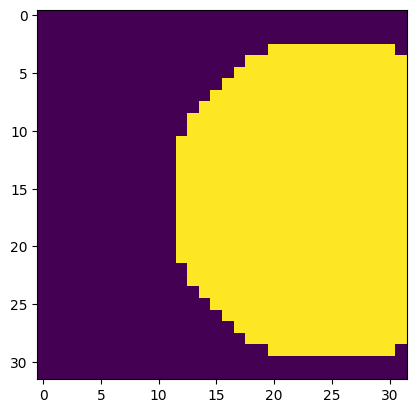

In [62]:
plt.imshow(Xval[0, 0, :, :].to("cpu"))

In [64]:
from matplotlib.patches import Rectangle, Circle

In [133]:
Yval_detec_plot = model_cnn.detection(Xval[idx_detec:idx_detec+1])
Yval_detec_plot.shape

torch.Size([1, 3])

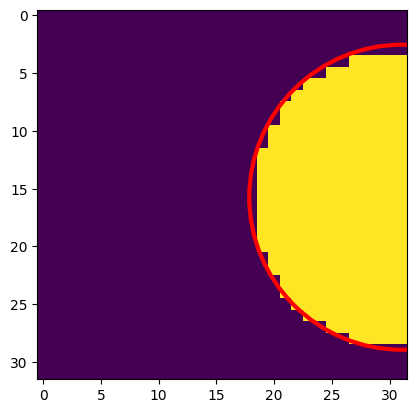

In [147]:
fig, ax = plt.subplots()
idx_detec = 100
#Yval_detec_plot = Yval_detec[idx_detec, :].to("cpu")
Yval_detec_plot = model_cnn.detection(Xval[idx_detec:idx_detec+1]).to("cpu").detach().numpy()
ax.imshow(Xval[idx_detec, 0, :, :].to("cpu"))
if idx_detec < 500:
  c = Circle((Yval_detec_plot[0, :2]), Yval_detec_plot[0, 2], fill=False, linewidth=3, color="red")
else:
  c = Rectangle(Yval_detec_plot[0, :2], Yval_detec_plot[0, 2].item(), Yval_detec_plot[0, 2].item(), fill=False, color="red")

ax.add_patch(c)